# Komplettes Skript

In [64]:
# mini_cifar10_cnn.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ---- Setup ----
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")
torch.manual_seed(0)

# CIFAR-10: 32x32 RGB, Klassen=10
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2470, 0.2435, 0.2616)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2470, 0.2435, 0.2616)),
])

train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_ds  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=1, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=1, pin_memory=True)

# ---- Kleines CNN ----
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)   # 32x32 -> 32x32
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # 32x32 -> 32x32
        self.pool  = nn.MaxPool2d(2, 2)               # 32x32 -> 16x16
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # 16x16 -> 16x16
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)# 16x16 -> 16x16
        self.head  = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),                  # -> 128x1x1
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        print("Nach conv1 hat Tensor die Shape:", x.shape)
        x = F.relu(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.head(x)
        return x

model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 1

# ---- Training ----
for epoch in range(1, epochs + 1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # ---- Evaluation ----
    model.eval()
    correct, total, test_loss = 0, 0, 0.0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            loss = criterion(logits, labels)
            test_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_loss /= total
    test_acc = correct / total
    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} acc={train_acc:.3f} | "
          f"test_loss={test_loss:.4f} acc={test_acc:.3f}")

# Optional: Modell speichern
torch.save(model.state_dict(), "small_cifar10_cnn.pt")
print("Saved to small_cifar10_cnn.pt")


Nach conv1 hat Tensor die Shape: torch.Size([128, 32, 32, 32])
Nach conv1 hat Tensor die Shape: torch.Size([128, 32, 32, 32])
Nach conv1 hat Tensor die Shape: torch.Size([128, 32, 32, 32])
Nach conv1 hat Tensor die Shape: torch.Size([128, 32, 32, 32])
Nach conv1 hat Tensor die Shape: torch.Size([128, 32, 32, 32])
Nach conv1 hat Tensor die Shape: torch.Size([128, 32, 32, 32])
Nach conv1 hat Tensor die Shape: torch.Size([128, 32, 32, 32])
Nach conv1 hat Tensor die Shape: torch.Size([128, 32, 32, 32])
Nach conv1 hat Tensor die Shape: torch.Size([128, 32, 32, 32])
Nach conv1 hat Tensor die Shape: torch.Size([128, 32, 32, 32])
Nach conv1 hat Tensor die Shape: torch.Size([128, 32, 32, 32])
Nach conv1 hat Tensor die Shape: torch.Size([128, 32, 32, 32])
Nach conv1 hat Tensor die Shape: torch.Size([128, 32, 32, 32])
Nach conv1 hat Tensor die Shape: torch.Size([128, 32, 32, 32])
Nach conv1 hat Tensor die Shape: torch.Size([128, 32, 32, 32])
Nach conv1 hat Tensor die Shape: torch.Size([128, 32, 3

KeyboardInterrupt: 

In [3]:
type(train_ds)

torchvision.datasets.cifar.CIFAR10

In [50]:
train_ds.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [51]:
train_ds.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [6]:
len(train_ds.classes)

10

In [8]:
len(train_ds)

50000

In [9]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [10]:
len(train_loader)

391

In [11]:
train_loader.batch_size

128

In [22]:
import math
math.ceil( len(train_ds) / train_loader.batch_size )

391

In [20]:
import math
math.ceil(1.1)

2

In [53]:
for imgs, labels in train_loader:
    print(imgs.shape)
    print(labels.shape)
    break

torch.Size([128, 3, 32, 32])
torch.Size([128])


In [25]:
labels[:5]

tensor([9, 2, 3, 4, 5])

In [26]:
train_ds.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


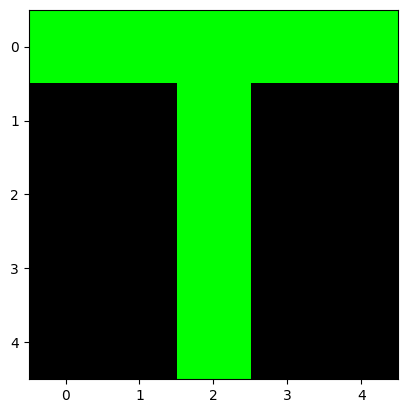

array([[[  0., 255.,   0.],
        [  0., 255.,   0.],
        [  0., 255.,   0.],
        [  0., 255.,   0.],
        [  0., 255.,   0.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0., 255.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0., 255.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0., 255.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0., 255.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]]])

In [44]:
import matplotlib.pyplot as plt

import numpy
img = numpy.zeros(shape=(5,5,3))

img[0,:,0] = 0
img[0,:,1] = 255
img[0,:,2] = 0

img[:,2,1] = 255

plt.imshow(img)
plt.show()

img

In [55]:
labels

tensor([2, 9, 9, 9, 5, 5, 8, 5, 1, 3, 4, 1, 0, 9, 7, 9, 7, 3, 1, 8, 6, 7, 8, 4,
        4, 8, 5, 8, 8, 1, 3, 5, 7, 7, 5, 5, 4, 2, 3, 4, 1, 8, 7, 5, 7, 8, 3, 7,
        6, 6, 2, 1, 6, 0, 1, 0, 5, 9, 8, 7, 7, 2, 1, 1, 3, 0, 3, 6, 6, 7, 7, 7,
        9, 0, 1, 9, 7, 6, 0, 5, 7, 1, 4, 6, 2, 6, 7, 4, 9, 1, 3, 1, 4, 6, 0, 9,
        5, 7, 4, 4, 5, 8, 9, 2, 6, 3, 2, 9, 9, 3, 7, 0, 9, 3, 7, 4, 8, 9, 4, 7,
        4, 8, 7, 0, 5, 9, 2, 6])

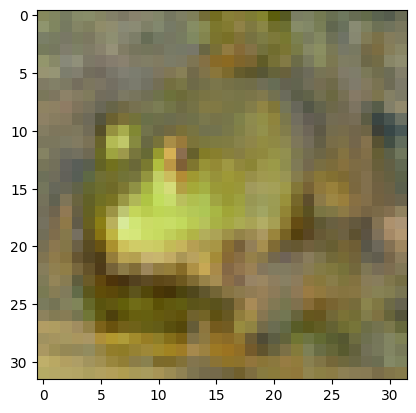

tensor([[[0.5255, 0.5373, 0.3647],
         [0.5059, 0.5255, 0.3765],
         [0.4667, 0.4863, 0.3765],
         ...,
         [0.3529, 0.3882, 0.3098],
         [0.3333, 0.3608, 0.3020],
         [0.4157, 0.4235, 0.3333]],

        [[0.5608, 0.5843, 0.4314],
         [0.5020, 0.5255, 0.3765],
         [0.4627, 0.4784, 0.3765],
         ...,
         [0.4275, 0.4431, 0.3333],
         [0.4392, 0.4510, 0.3608],
         [0.4745, 0.4667, 0.3647]],

        [[0.4784, 0.4980, 0.4039],
         [0.4706, 0.4863, 0.3804],
         [0.4745, 0.4706, 0.3961],
         ...,
         [0.4824, 0.4431, 0.2824],
         [0.5176, 0.4863, 0.3569],
         [0.5020, 0.4863, 0.3725]],

        ...,

        [[0.6667, 0.5961, 0.3843],
         [0.6157, 0.5608, 0.3373],
         [0.5843, 0.5333, 0.3333],
         ...,
         [0.4667, 0.4706, 0.3569],
         [0.5098, 0.5216, 0.3882],
         [0.4706, 0.4784, 0.3490]],

        [[0.7490, 0.6863, 0.4157],
         [0.7255, 0.6588, 0.3882],
         [0.

In [59]:
import matplotlib.pyplot as plt

img = imgs[-1,:,:,:].permute(1,2,0)

plt.imshow(img)
plt.show()

img

In [61]:
len(test_ds)

10000

In [63]:
10000 / 256

39.0625

Variante 2 mit Zeitmessung, adaptiver Anzahl an Epochen, Modellspeicherung

In [69]:
# mini_cifar10_cnn_earlystop.py
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ---- Setup ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

# CIFAR-10: 32x32 RGB, Klassen=10
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2470, 0.2435, 0.2616)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2470, 0.2435, 0.2616)),
])

train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_ds  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=1, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=1, pin_memory=True)

# ---- Kleines CNN ----
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)   # 32x32 -> 32x32
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # 32x32 -> 32x32
        self.pool  = nn.MaxPool2d(2, 2)               # 32x32 -> 16x16
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # 16x16 -> 16x16
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)# 16x16 -> 16x16
        self.head  = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),                  # -> 128x1x1
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.head(x)
        return x

model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ---- Early Stopping Setup ----
patience = 5                 # Stoppe, wenn sich val loss 5 Epochen nicht verbessert
best_val_loss = float("inf")
epochs_no_improve = 0
epoch = 0
best_model_path = "best_small_cifar10_cnn.pt"

# ---- Training Loop (ohne feste Epochen-Anzahl) ----
while epochs_no_improve < patience:
    epoch += 1

    # ---- Training ----
    model.train()
    start_train = time.perf_counter()
    running_loss, correct, total = 0.0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_time = time.perf_counter() - start_train
    train_loss = running_loss / total
    train_acc = correct / total

    # ---- Evaluation ----
    model.eval()
    start_eval = time.perf_counter()
    correct, total, test_loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            loss = criterion(logits, labels)
            test_loss_sum += loss.item() * imgs.size(0)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    eval_time = time.perf_counter() - start_eval
    val_loss = test_loss_sum / total
    val_acc = correct / total

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_loss:.4f} acc={train_acc:.3f} "
        f"(train_time={train_time:.2f}s) | "
        f"val_loss={val_loss:.4f} acc={val_acc:.3f} "
        f"(eval_time={eval_time:.2f}s)"
    )

    # ---- Early Stopping & Best Model Speichern ----
    if val_loss < best_val_loss - 1e-6:  # kleiner Toleranzwert verhindert Flattern
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"➜ Neues bestes Modell gespeichert: {best_model_path} (val_loss={best_val_loss:.4f})")
    else:
        epochs_no_improve += 1

print(
    f"Training beendet nach {epoch} Epochen "
    f"(keine Verbesserung der Val-Loss für {patience} Epochen)."
)
print(f"Bestes Modell liegt unter: {best_model_path}")


Epoch 01 | train_loss=1.8271 acc=0.297 (train_time=6.54s) | val_loss=1.6219 acc=0.382 (eval_time=0.82s)
➜ Neues bestes Modell gespeichert: best_small_cifar10_cnn.pt (val_loss=1.6219)
Epoch 02 | train_loss=1.5290 acc=0.428 (train_time=6.58s) | val_loss=1.3981 acc=0.491 (eval_time=0.81s)
➜ Neues bestes Modell gespeichert: best_small_cifar10_cnn.pt (val_loss=1.3981)
Epoch 03 | train_loss=1.3463 acc=0.511 (train_time=6.54s) | val_loss=1.2840 acc=0.545 (eval_time=0.83s)
➜ Neues bestes Modell gespeichert: best_small_cifar10_cnn.pt (val_loss=1.2840)
Epoch 04 | train_loss=1.2110 acc=0.563 (train_time=6.59s) | val_loss=1.1491 acc=0.585 (eval_time=0.83s)
➜ Neues bestes Modell gespeichert: best_small_cifar10_cnn.pt (val_loss=1.1491)
Epoch 05 | train_loss=1.1203 acc=0.600 (train_time=6.55s) | val_loss=1.1322 acc=0.597 (eval_time=0.80s)
➜ Neues bestes Modell gespeichert: best_small_cifar10_cnn.pt (val_loss=1.1322)
Epoch 06 | train_loss=1.0569 acc=0.624 (train_time=6.55s) | val_loss=1.0188 acc=0.640

In [65]:
float("inf")

inf

In [70]:
print("Hallo")

Hallo
